## LGMVIP - DataScience task #3 Beginner level: Music Recommendation system LGBM
### Author: Zakaria Jnayni
### Import Libraries

### Importing libraries

In [13]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
import missingno as msno
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score, accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgbm

In [34]:
# Unziping Data
#!7z e "../input/kkbox-music-recommendation-challenge/members.csv.7z"
#!7z e "../input/kkbox-music-recommendation-challenge/songs.csv.7z"
#!7z e "../input/kkbox-music-recommendation-challenge/test.csv.7z"
#!7z e "../input/kkbox-music-recommendation-challenge/train.csv.7z"
#!7z e "../input/kkbox-music-recommendation-challenge/song_extra_info.csv.7z"

### Load dataset

In [3]:
train = pd.read_csv('train.csv')
songs = pd.read_csv('songs.csv')
members = pd.read_csv('members.csv')
songs_extra = pd.read_csv('song_extra_info.csv')

### Merge the dataframes

In [10]:
t1 = pd.merge(train, songs, on='song_id', how='left')
t2 = pd.merge(t1, songs_extra, on='song_id', how='left')
train_df = pd.merge(t2, members, on='msno', how='left')

In [11]:
# delete
del songs, songs_extra, members, train, t1, t2

In [40]:
train_df.head()

,msno,song_id,source_system_tab,source_screen_name,source_type,target,song_length,genre_ids,artist_name,composer,...,gender,registered_via,registration_init_time,expiration_date,registration_init_time_year,registration_init_time_month,registration_init_time_day,expiration_date_year,expiration_date_month,expiration_date_day
0,8158,74679,1,7,6,1,19020,285,3277,14581,...,2,2,2131,989,8,0,1,14,9,4
1,17259,223479,3,8,4,1,36985,90,31960,64996,...,0,3,1909,965,7,4,24,14,8,10
2,17259,120758,3,8,4,1,23675,90,21372,45057,...,0,3,1909,965,7,4,24,14,8,10
3,17259,23707,3,8,4,1,30970,6,27439,36700,...,0,3,1909,965,7,4,24,14,8,10
4,8158,33308,1,7,6,1,14877,2,4472,8485,...,2,2,2131,989,8,0,1,14,9,4


### Missing values

<AxesSubplot:>

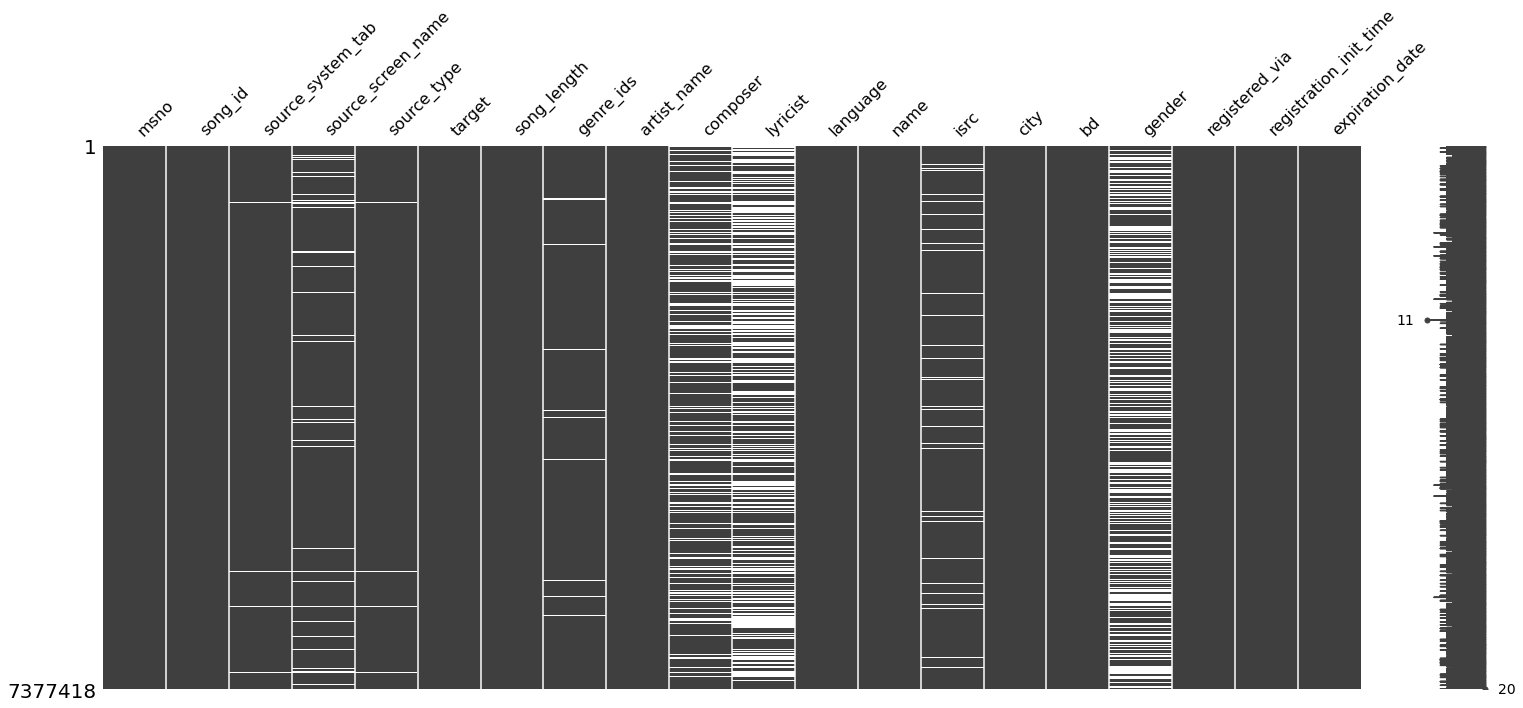

In [14]:
msno.matrix(train_df)

We fill the missing values

In [15]:
# for objects 
for col in train_df.select_dtypes(include=['object']).columns:
    train_df[col] = train_df[col].fillna(value = "unknown")
# for values 
for col in train_df.select_dtypes(exclude=['object']).columns:
    train_df[col] = train_df[col].fillna(value = train_df[col].mean())

In [16]:
train_df.isna().sum()

msno                      0
song_id                   0
source_system_tab         0
source_screen_name        0
source_type               0
target                    0
song_length               0
genre_ids                 0
artist_name               0
composer                  0
lyricist                  0
language                  0
name                      0
isrc                      0
city                      0
bd                        0
gender                    0
registered_via            0
registration_init_time    0
expiration_date           0
dtype: int64

### Features engineering
We extract the date features, and we code labels

In [19]:
# Extract features from registration date
train_df.registration_init_time = pd.to_datetime(train_df.registration_init_time, format='%Y%m%d', errors='ignore')
train_df['registration_init_time_year'] = train_df['registration_init_time'].dt.year
train_df['registration_init_time_month'] = train_df['registration_init_time'].dt.month
train_df['registration_init_time_day'] = train_df['registration_init_time'].dt.day

In [20]:
# Extract features from expiration date
train_df.expiration_date = pd.to_datetime(train_df.expiration_date,  format='%Y%m%d', errors='ignore')
train_df['expiration_date_year'] = train_df['expiration_date'].dt.year
train_df['expiration_date_month'] = train_df['expiration_date'].dt.month
train_df['expiration_date_day'] = train_df['expiration_date'].dt.day

In [22]:
# coding the labels
label_encoder = LabelEncoder()

In [23]:
for i in train_df.columns:
    train_df[i] = label_encoder.fit_transform(train_df[i])

### LGBM Model

In [24]:
# Train Test split
X = train_df.drop('target', axis = 1)
y = train_df.target

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.25, random_state = 0)

In [25]:
lgbm_clf = lgbm.LGBMClassifier(learning_rate=0.3, n_estimators=100)
lgbm_clf.fit(X_train, y_train)

LGBMClassifier(learning_rate=0.3)

In [47]:
y_pred_lgbm = lgbm_clf.predict(X_val)
print('LightGBM Model accuracy score: {0:0.4f}'.format(accuracy_score(y_val, y_pred_lgbm)))

ValueError: Classification metrics can't handle a mix of binary and continuous targets

In [29]:
print(classification_report(y_val, y_pred_lgbm))

              precision    recall  f1-score   support

           0       0.66      0.63      0.64    915850
           1       0.65      0.68      0.67    928505

    accuracy                           0.66   1844355
   macro avg       0.66      0.66      0.66   1844355
weighted avg       0.66      0.66      0.66   1844355



### Confusion matrix

<AxesSubplot:>

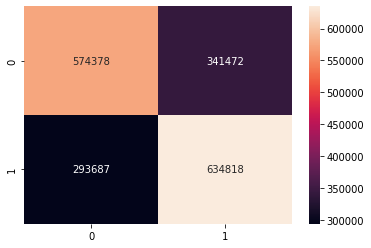

In [33]:
import seaborn as sns 
from sklearn.metrics import confusion_matrix

cm_lgbm = confusion_matrix(y_val, y_pred_lgbm)
sns.heatmap(cm_lgbm, annot=True, fmt='g')